In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm # a nice progress bar

In [2]:
# generate a dataset of 1D data from a mixture of two Gaussians
# this is a simple example, but you can use any distribution
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2])),  #ratio 1:2 of falling into one distribution vs the other
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
)

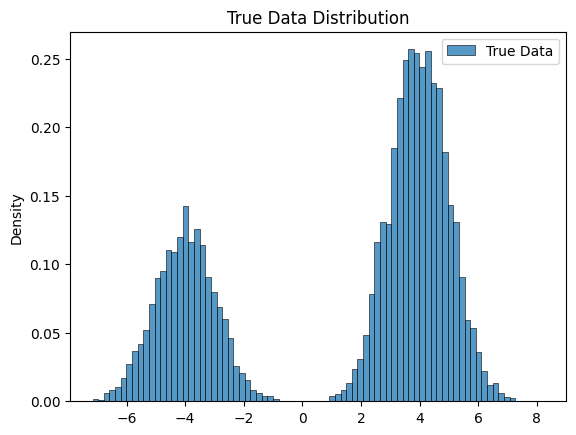

In [3]:
dataset = data_distribution.sample(torch.Size([10000]))  # create training data set
dataset_validation = data_distribution.sample(torch.Size([1000])) # create validation data set

# Plot the true distribution
sns.histplot(dataset.numpy(), stat='density', bins=80, label='True Data')
plt.legend()
plt.title("True Data Distribution")
plt.show()

In [9]:
#Set hyperparameters
TIME_STEPS = 250
BETA = torch.tensor(0.02)
ALPHA = 1.0 - BETA
ALPHABAR = torch.cumprod(torch.full((TIME_STEPS,), ALPHA), dim=0)

N_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 8e-4


In [5]:
# two inputs (the current data and the time step)
# one output (the predicted noise)
class NoisePredictorMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
###GPT
    def forward(self, x, t):
        # Normalize time and concatenate with x_t
        t = t.float().unsqueeze(1) / TIME_STEPS
        x = x.unsqueeze(1)
        return self.model(torch.cat([x, t], dim=1)).squeeze(1)

g = NoisePredictorMLP()
optimizer = torch.optim.Adam(g.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()


In [6]:
#training loop
epochs = tqdm(range(N_EPOCHS))
for epoch in epochs:
    g.train()
    indices = torch.randperm(len(dataset))
    for i in range(0, len(dataset) - BATCH_SIZE, BATCH_SIZE):
        x0 = dataset[indices[i:i + BATCH_SIZE]]

        # Sample time step and noise
        t = torch.randint(0, TIME_STEPS, (BATCH_SIZE,))
        alpha_bar = ALPHABAR[t].unsqueeze(1)
        epsilon = torch.randn_like(x0)

        # Create noisy version x_t
        xt = torch.sqrt(alpha_bar) * x0.unsqueeze(1) + torch.sqrt(1 - alpha_bar) * epsilon.unsqueeze(1)
        xt = xt.squeeze(1)

        # Predict epsilon and compute loss
        pred_epsilon = g(xt, t)
        loss = loss_fn(pred_epsilon, epsilon)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
@torch.no_grad()
def sample_reverse(g, count):
    g.eval()
    x = torch.randn(count)  # Start from pure noise

    for t in reversed(range(1, TIME_STEPS)):
        t_batch = torch.full((count,), t, dtype=torch.long)
        beta = BETA
        alpha = ALPHA
        alpha_bar = ALPHABAR[t]

        z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
        pred_epsilon = g(x, t_batch)

        x = (1 / torch.sqrt(alpha)) * (
            x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * pred_epsilon
        ) + torch.sqrt(beta) * z

    return x


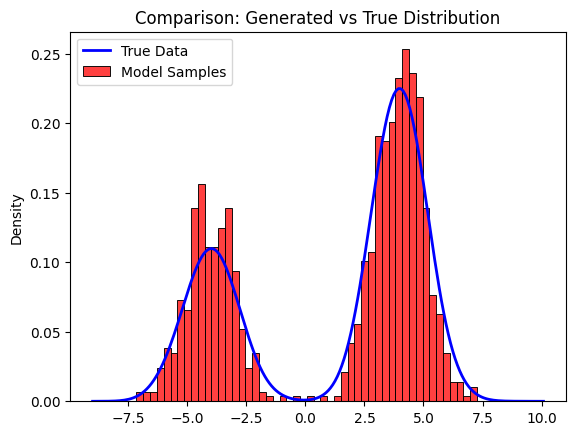

In [10]:
samples = sample_reverse(g, 1000).numpy()

sns.histplot(samples, stat='density', bins=50, color='red', label='Model Samples')
sns.kdeplot(dataset.numpy(), color='blue', label='True Data', linewidth=2)
plt.title("Comparison: Generated vs True Distribution")
plt.legend()
plt.show()


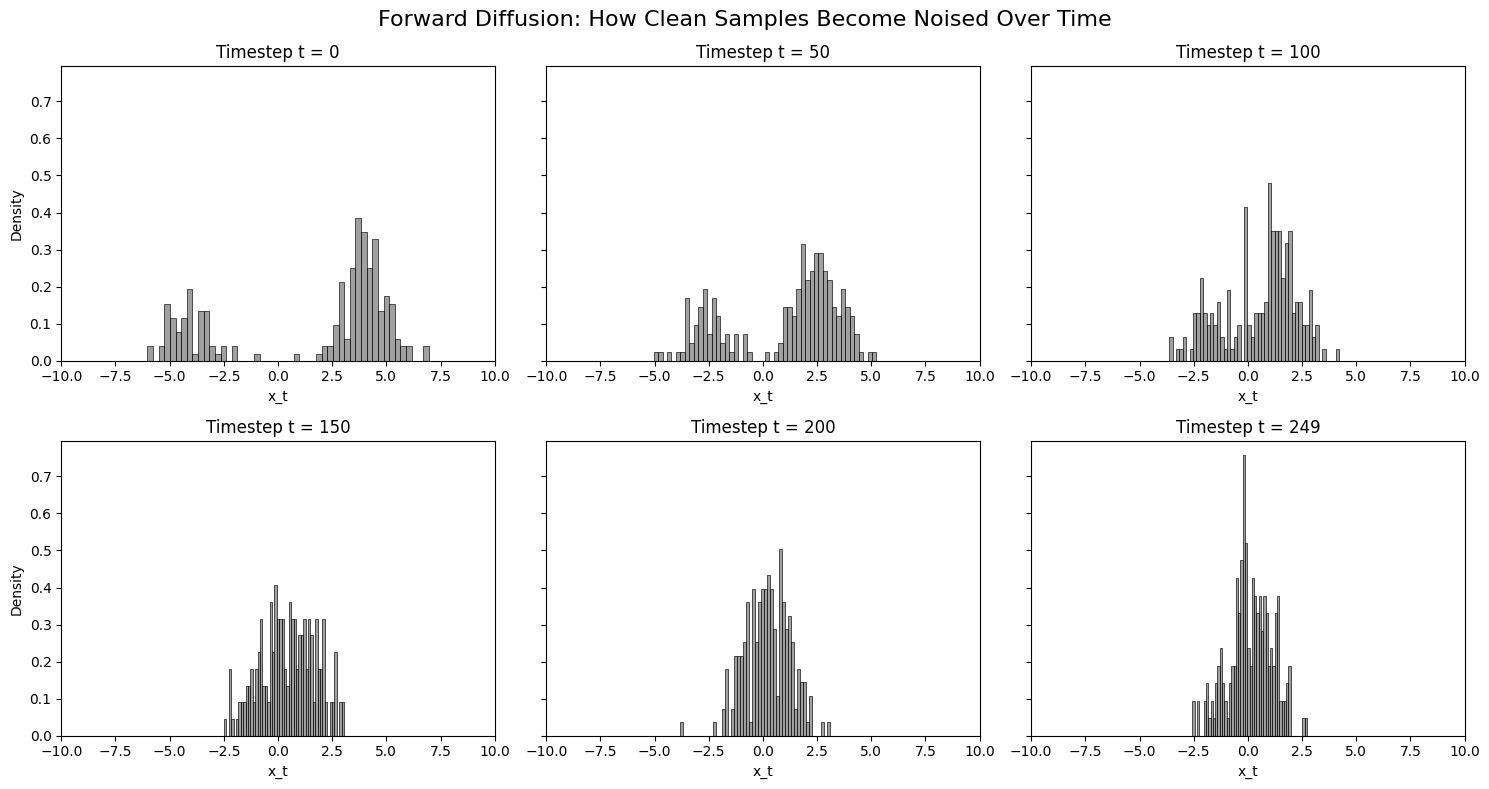

In [11]:
# ---------------------------------------------
# Visualization: How samples are transformed with increasing diffusion steps
# ---------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Sample from the actual data distribution (mixture of Gaussians)
x0_vis = data_distribution.sample(torch.Size([200]))  # same as training distribution

# Select timesteps to visualize
timesteps = [0, 50, 100, 150, 200, 249]
xt_distributions = []

# Apply forward diffusion at selected timesteps
for t in timesteps:
    alpha_bar_t = ALPHABAR[t]
    eps = torch.randn_like(x0_vis)
    xt = torch.sqrt(alpha_bar_t) * x0_vis + torch.sqrt(1 - alpha_bar_t) * eps
    xt_distributions.append(xt)

# Plot the evolution of the distribution over time
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()
for i, t in enumerate(timesteps):
    sns.histplot(xt_distributions[i].numpy(), bins=50, stat='density', ax=axes[i], color='gray')
    axes[i].set_title(f"Timestep t = {t}")
    axes[i].set_xlim([-10, 10])
    axes[i].set_xlabel("x_t")
    axes[i].set_ylabel("Density")

plt.suptitle("Forward Diffusion: How Clean Samples Become Noised Over Time", fontsize=16)
plt.tight_layout()
plt.show()
